# EDA

## Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2  # 1 would be where you need to specify the files
#%aimport data_fcns

import pandas as pd  # dataframes
import os
import gspread_pandas
from gspread_pandas import Spread, Client  # gsheets interaction

# Data storage
from sqlalchemy import create_engine  # SQL helper
import psycopg2 as psql  #PostgreSQL DBs

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys

In [3]:
sys.path.append("..")

In [4]:
# Custom
import data_fcns as dfc
import keys  # Custom keys lib

# Distribution of Accounts

The distribution of acccounts may help influence the result. Let's try to identify:

- "Super accounts" - e.g. one of the accounts is earmarked for eBay transactions.
- One-time customers - Customers who only purchased once may cloud the data.

### Get transactions data

In [5]:
# Define path to secret
secret_path_aws = os.path.join(os.environ['HOME'], '.secret',
                               'aws_ps_flatiron.json')
secret_path_aws

'/Users/werlindo/.secret/aws_ps_flatiron.json'

In [6]:
aws_keys = keys.get_keys(secret_path_aws)
user = aws_keys['user']
ps = aws_keys['password']
host = aws_keys['host']
db = aws_keys['db_name']

aws_ps_engine = ('postgresql://' + user + ':' + ps + '@' + host + '/' + db)

In [7]:
# Setup PSQL connection
conn = psql.connect(database=db,
                    user=user,
                    password=ps,
                    host=host,
                    port='5432')

In [8]:
# Instantiate cursor
cur = conn.cursor()

In [9]:
#  Count records.
query = """
    SELECT
        account_num
        ,COUNT(DISTINCT comic_title) num_title_bought 
    FROM 
        comic_trans 
    GROUP BY
        account_num
    ORDER BY 
        2 DESC
    ;
"""

In [10]:
# Execute the query
cur.execute(query)

In [11]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [12]:
temp_df.head(10)

,account_num,num_title_bought
0,00191,1504
1,00961,1114
2,01132,1023
3,01695,944
4,00134,925
5,00174,838
6,01047,730
7,01858,715
8,01275,694
9,00108,652


In [13]:
#  Count records.
query = """
    SELECT * from comic_trans limit 10;
"""

In [14]:
temp_df.tail(10)

,account_num,num_title_bought
1707,01217,1
1708,03011,1
1709,00902,1
1710,00911,1
1711,01630,1
1712,00313,1
1713,00926,1
1714,00931,1
1715,03015,1
1716,03016,1


In [15]:
temp_df.shape

(1717, 2)

- There are 1.7K accounts who bought at least 1 title  
- The top end doesn't seem as skewed as I thought it would, at least at first blush.

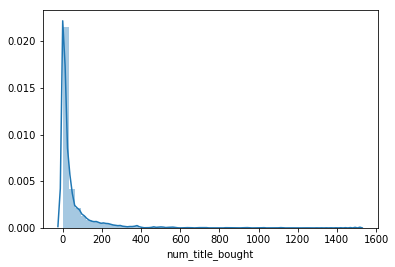

In [16]:
sns.distplot(temp_df.num_title_bought)

Well, don't really know what I meant by the prior comment re: skewness. I think what I mean is that my prior guess was that the 'top' account would number in the high thousands, though that was more of a, like I said, guess.

Could always just set up high and low thresholds, and just set them as get more info.

In [17]:
# Thresholds
bottom = 1
top = 100

In [18]:
small_df = temp_df.loc[(temp_df.num_title_bought > bottom)
                       & (temp_df.num_title_bought < top)]

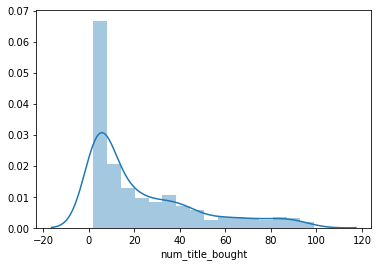

In [19]:
sns.distplot(small_df.num_title_bought)

In [20]:
small_df['num_title_bought'].value_counts().head(20)

2     125
3     108
4      76
6      51
7      40
5      39
8      36
9      36
10     34
11     27
12     23
18     20
35     19
19     17
13     15
20     15
37     15
23     14
27     14
15     14
Name: num_title_bought, dtype: int64

Definitely skewed. Just from visual inspection from playing around with the thresholds and looking at the `value_counts`, just set some arbitrary limits of:  
- bottom: 5
- top : 250

Let's create a table on our DB that is `account_num` by `num_title_bought`

#  Create account counts table.
query = """
    CREATE TABLE acct_cts AS
    SELECT
        account_num
        ,COUNT(DISTINCT comic_title) num_title_bought 
    FROM 
        comic_trans 
    GROUP BY
        account_num
    ;
"""

In [18]:
# Execute the query
cur.execute(query)

In [19]:
conn.commit()

Check it.

In [21]:
#  Count records.
query = """
    SELECT *
    FROM acct_cts
    --WHERE num_title_bought between 5 and 250
    WHERE num_title_bought > 250 
    ORDER BY num_title_bought DESC
    ;
"""

In [22]:
# Execute the query
cur.execute(query)

In [23]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [24]:
temp_df

,account_num,num_title_bought
0,00191,1504
1,00961,1114
2,01132,1023
3,01695,944
4,00134,925
5,00174,838
6,01047,730
7,01858,715
8,01275,694
9,00108,652


Should we also subset on dates to control for tastes changing over time?

In [25]:
query = """
    SELECT * FROM comic_trans 
    WHERE date_sold >= '2018-01-01'
    limit 10;
"""

In [26]:
# Execute the query
cur.execute(query)

In [27]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [28]:
temp_df

,index,publisher,item_id,title_and_num,qty_sold,date_sold,account_num,comic_title
0,471,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-17 12:07:25,02247,Archie (Archie)
1,472,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-19 12:18:23,01573,Archie (Archie)
2,473,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-21 10:28:06,00280,Archie (Archie)
3,474,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-18 17:02:55,02163,Archie (Archie)
4,475,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-12 14:18:12,00961,Archie (Archie)
5,476,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-18 17:57:15,00161,Archie (Archie)
6,477,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-02-22 13:43:41,02224,Archie (Archie)
7,478,Archie Comics,DCDL071881,Archie #28 Cvr A Mok,1,2018-02-26 17:36:16,02163,Archie (Archie)
8,479,Archie Comics,DCDL071881,Archie #28 Cvr A Mok,1,2018-02-18 10:05:33,00280,Archie (Archie)
9,480,Archie Comics,DCDL071881,Archie #28 Cvr A Mok,1,2018-02-16 14:49:33,02247,Archie (Archie)


Date filtering works. Super arbitrary? 
- Is there an effect from other pop culture influence:
- Marvel movies? (e.g. Iron Man 2008, Avengers 2012, etc)

I thnk safe for now is to just either take it all? or Just settle on some rule of thumb for now: e.g. 5 years.


## Conclusions
#### 2019.06.26 11am

- set minimum at 5
- set maximum at ~~250~~ 300
- No date filter
- min floor on sum(qty) = 50

In [58]:
min_titles = 5
max_titles = 300
min_sold = 50

In [59]:
query = """
    SELECT ct.* 
    FROM 
        comic_trans ct 
        INNER JOIN acct_cts ac on ct.account_num = ac.account_num
        INNER JOIN (
                    SELECT
                        comic_title
                    FROM
                        comic_trans ct
                    GROUP BY
                        comic_title
                    HAVING SUM(qty_sold) >= {}       
                    ) c on ct.comic_title = c.comic_title
    WHERE
        ac.num_title_bought between {} and {};
""".format(min_sold, min_titles, max_titles)

In [60]:
query

'\n    SELECT ct.* \n    FROM \n        comic_trans ct \n        INNER JOIN acct_cts ac on ct.account_num = ac.account_num\n        INNER JOIN (\n                    SELECT\n                        comic_title\n                    FROM\n                        comic_trans ct\n                    GROUP BY\n                        comic_title\n                    HAVING SUM(qty_sold) >= 50       \n                    ) c on ct.comic_title = c.comic_title\n    WHERE\n        ac.num_title_bought between 5 and 300;\n'

In [61]:
# Execute the query
cur.execute(query)

In [62]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

conn.rollback()

In [63]:
temp_df.head()

,index,publisher,item_id,title_and_num,qty_sold,date_sold,account_num,comic_title
0,13,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-01-23 19:36:29,01033,Afterlife With Archie (Archie)
1,16,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-05-01 12:37:14,01333,Afterlife With Archie (Archie)
2,17,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-05-12 14:15:56,00946,Afterlife With Archie (Archie)
3,19,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-08-13 18:25:35,01278,Afterlife With Archie (Archie)
4,21,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2013-11-06 15:21:10,01212,Afterlife With Archie (Archie)


In [64]:
temp_df.shape

(288062, 8)

In [65]:
288 / 495 - 1

-0.4181818181818182

Doing that filter would reduce our starting dataset by about 40%. Let's go with it and see what it looks like.

In [66]:
com_cts = pd.DataFrame(temp_df['comic_title'].value_counts())

In [67]:
com_cts.head()

,comic_title
Batman (DC),6580
Walking Dead (Image),5051
Saga (Image),4268
Amazing Spider-Man (Marvel),3557
Uncanny X-Men (Marvel),3161


In [33]:
com_cts['comic_title'].sum()

288062

#### # of `account_num` | `comic_title` pairings

In [43]:
query = """
    SELECT
        ac.account_num
        ,ct.comic_title
    FROM 
        comic_trans ct 
        INNER JOIN acct_cts ac on ct.account_num = ac.account_num
        INNER JOIN (
                    SELECT
                        comic_title
                    FROM
                        comic_trans ct
                    GROUP BY
                        comic_title
                    HAVING SUM(qty_sold) >= {}       
                    ) c on ct.comic_title = c.comic_title
    WHERE
        ac.num_title_bought between {} and {}
    GROUP BY
        ac.account_num
        ,ct.comic_title
""".format(min_sold, min_titles, max_titles)

In [44]:
query

'\n    SELECT\n        ac.account_num\n        ,ct.comic_title\n    FROM \n        comic_trans ct \n        INNER JOIN acct_cts ac on ct.account_num = ac.account_num\n        INNER JOIN (\n                    SELECT\n                        comic_title\n                    FROM\n                        comic_trans ct\n                    GROUP BY\n                        comic_title\n                    HAVING SUM(qty_sold) >= 50       \n                    ) c on ct.comic_title = c.comic_title\n    WHERE\n        ac.num_title_bought between 5 and 300\n    GROUP BY\n        ac.account_num\n        ,ct.comic_title\n'

In [53]:
# Execute the query
cur.execute(query)

In [54]:
# Check results
tempacct_df = pd.DataFrame(cur.fetchall())
tempacct_df.columns = [col.name for col in cur.description]

conn.rollback()

In [56]:
tempacct_df.head()

,account_num,comic_title
0,00002,All New X-Men (Marvel)
1,00002,Amazing Spider-Man Annual (Marvel)
2,00002,Amazing Spider-Man (Marvel)
3,00002,A Plus X (Marvel)
4,00002,Avengers (Marvel)


In [57]:
tempacct_df.shape

(40174, 2)

# Create Smaller Dataset

Latest instance of the target table is `temp_df`. So just run with that.

Drop `index`

In [68]:
temp_df = temp_df.drop(['index'], axis=1)

In [69]:
temp_df.head()

,publisher,item_id,title_and_num,qty_sold,date_sold,account_num,comic_title
0,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-01-23 19:36:29,01033,Afterlife With Archie (Archie)
1,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-05-01 12:37:14,01333,Afterlife With Archie (Archie)
2,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-05-12 14:15:56,00946,Afterlife With Archie (Archie)
3,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-08-13 18:25:35,01278,Afterlife With Archie (Archie)
4,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2013-11-06 15:21:10,01212,Afterlife With Archie (Archie)


### Only uncomment below as needed.

In [70]:
temp_df.to_json('raw_data/trans_filtered_floor.json', orient='records', lines=True)

In [71]:
!head raw_data/trans_filtered.json

{"publisher":"Amaze Ink Slave Labor Graphics","item_id":"DCD416182","title_and_num":"Royal Historian of Oz #1","qty_sold":1,"date_sold":1279136980000,"account_num":"00399","comic_title":"Royal Historian of Oz (SLG)"}
{"publisher":"Amaze Ink Slave Labor Graphics","item_id":"DCD416182","title_and_num":"Royal Historian of Oz #1","qty_sold":1,"date_sold":1288543119000,"account_num":"00327","comic_title":"Royal Historian of Oz (SLG)"}
{"publisher":"Amaze Ink Slave Labor Graphics","item_id":"DCD423794","title_and_num":"Royal Historian of Oz #2","qty_sold":1,"date_sold":1288543119000,"account_num":"00327","comic_title":"Royal Historian of Oz (SLG)"}
{"publisher":"Amaze Ink Slave Labor Graphics","item_id":"DCD390709","title_and_num":"Warlord of Io & Other Stories","qty_sold":1,"date_sold":1412166247000,"account_num":"01065","comic_title":"Warlord of Io & Other Storie (SLG)"}
{"publisher":"Archie Comics","item_id":"DCD630105","title_and_num":"Afterlife With Archie #1 2nd P","qty_sold":1,"date_s

# Summary Metrics

Let's take a breath and figure out the breatch of the data we have to work with.

- Count of Transactions
- Count of Unique Customers
- Distribution of Purchases



## Entire Dataset

#### How many transactions?

In [41]:
query = """
    SELECT count(*) 
    FROM 
        comic_trans ct 
    ;
    """

In [42]:
# Execute the query
cur.execute(query)

In [43]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [44]:
temp_df

,count
0,494703


#### How many Unique Customers?

In [45]:
query = """
    SELECT 
        COUNT(DISTINCT account_num) AS NUM_ACCTS 
    FROM 
        comic_trans ct 
    ;
    """

In [46]:
# Execute the query
cur.execute(query)

In [47]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [48]:
temp_df

,num_accts
0,1717


#### Distribution of Titles Bought

In [50]:
#  Count records.
query = """
    SELECT
        account_num
        ,COUNT(DISTINCT comic_title) num_title_bought 
    FROM 
        comic_trans 
    GROUP BY
        account_num
    ORDER BY 
        2 DESC
    ;
"""

In [51]:
# Execute the query
cur.execute(query)

In [52]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

Text(0.5, 1.0, 'Distribution of # of Titles Bought')

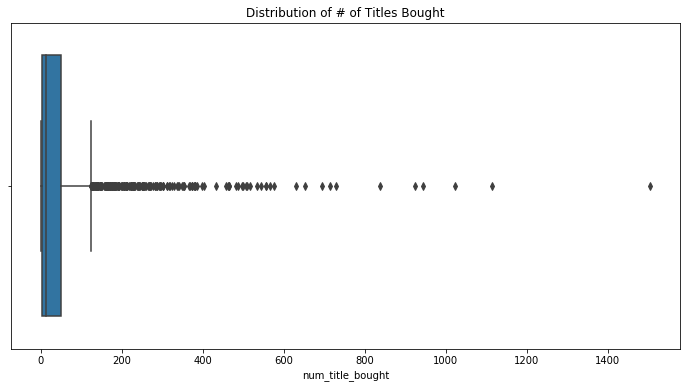

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=temp_df, x='num_title_bought')
ax.set_title("Distribution of # of Titles Bought")

Text(0.5, 1.0, 'Distribution of # of Titles Bought')

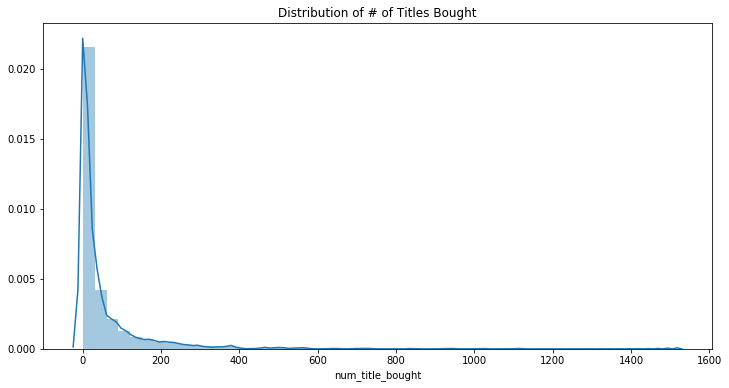

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.distplot(temp_df.num_title_bought)
ax.set_title("Distribution of # of Titles Bought")

In [56]:
temp_df.describe()

,num_title_bought
count,1717.000000
mean,53.638905
std,109.766430
min,1.000000
25%,3.000000
50%,12.000000
75%,51.000000
max,1504.000000


In [62]:
temp_df.median()

account_num         1280.0
num_title_bought      12.0
dtype: float64

## Reduced Dataset

#### How many transactions?

- set minimum at 5
- set maximum at ~~250~~ 300
- No date filter

query = """
    SELECT ct.* 
    FROM 
        comic_trans ct 
        INNER JOIN acct_cts ac on ct.account_num = ac.account_num
    WHERE
        ac.num_title_bought between {} and {};
""".format(min_titles, max_titles)

In [72]:
query = """
    SELECT
    ct.*
    FROM 
        comic_trans ct 
        INNER JOIN acct_cts ac on ct.account_num = ac.account_num
        INNER JOIN (
                    SELECT
                        comic_title
                    FROM
                        comic_trans ct
                    GROUP BY
                        comic_title
                    HAVING SUM(qty_sold) >= {}       
                    ) c on ct.comic_title = c.comic_title
    WHERE
        ac.num_title_bought between {} and {}
""".format(min_sold, min_titles, max_titles)

In [73]:
# Execute the query
cur.execute(query)

In [74]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [75]:
temp_df.shape[0]

288062

In [76]:
print("# of transactions reduced by {:.0f}%".format(
    (temp_df.shape[0]/494703-1)*100))

# of transactions reduced by -42%


#### How many Unique Customers?

In [77]:
temp_df['account_num'].nunique()

1067

In [78]:
print("# of accounts reduced by {:.0f}%".format(
    (temp_df['account_num'].nunique()/1717-1)*100))

# of accounts reduced by -38%


#### How many Unique Customers?

#### Distribution of Titles Bought

In [56]:
#  Count records.
query = """
    SELECT
        ct.account_num
        ,COUNT(DISTINCT comic_title) num_title_bought 
    FROM 
        comic_trans ct 
        INNER JOIN acct_cts ac on ct.account_num = ac.account_num
    WHERE
        ac.num_title_bought between {} and {}
    GROUP BY
        ct.account_num
    ;
    """.format(min_titles, max_titles)

In [83]:
query = """
    SELECT
        ct.account_num
        ,COUNT(DISTINCT ct.comic_title) num_title_bought 

    FROM 
        comic_trans ct 
        INNER JOIN acct_cts ac on ct.account_num = ac.account_num
        INNER JOIN (
                    SELECT
                        comic_title
                    FROM
                        comic_trans ct
                    GROUP BY
                        comic_title
                    HAVING SUM(qty_sold) >= {}       
                    ) c on ct.comic_title = c.comic_title
    WHERE
        ac.num_title_bought between {} and {}
    GROUP BY
        ct.account_num
""".format(min_sold, min_titles, max_titles)

In [84]:
query

'\n    SELECT\n        ct.account_num\n        ,COUNT(DISTINCT ct.comic_title) num_title_bought \n\n    FROM \n        comic_trans ct \n        INNER JOIN acct_cts ac on ct.account_num = ac.account_num\n        INNER JOIN (\n                    SELECT\n                        comic_title\n                    FROM\n                        comic_trans ct\n                    GROUP BY\n                        comic_title\n                    HAVING SUM(qty_sold) >= 50       \n                    ) c on ct.comic_title = c.comic_title\n    WHERE\n        ac.num_title_bought between 5 and 300\n    GROUP BY\n        ct.account_num\n'

In [85]:
# Execute the query
cur.execute(query)

In [86]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

Text(0.5, 1.0, 'Distribution of # of Titles Bought')

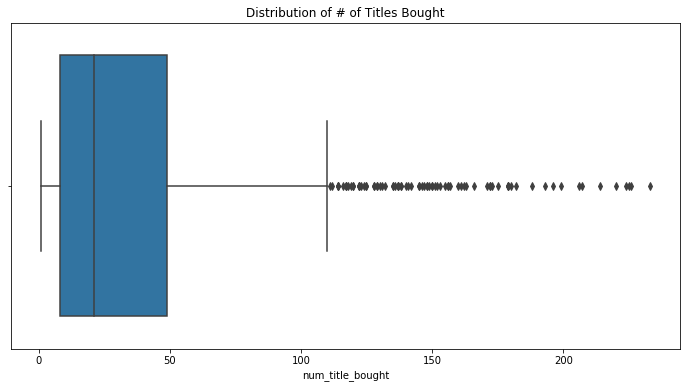

In [87]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=temp_df, x='num_title_bought')
ax.set_title("Distribution of # of Titles Bought")

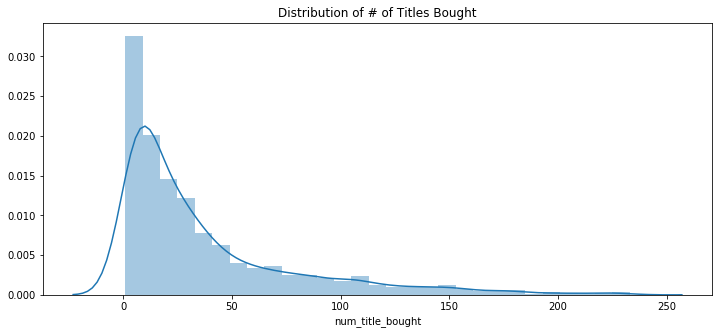

In [88]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.distplot(temp_df.num_title_bought)
ax.set_title("Distribution of # of Titles Bought")
plt.show()

In [89]:
temp_df.describe()

,num_title_bought
count,1067.000000
mean,37.651359
std,42.523366
min,1.000000
25%,8.000000
50%,21.000000
75%,49.000000
max,233.000000


In [90]:
temp_df.num_title_bought.sum()

40174

#### Am I (161) in the small set?

In [63]:
temp_df.loc[temp_df['account_num'] == '00161']

,account_num,num_title_bought
129,00161,295


~~Nope. Oh boy.~~

In [81]:
#  Count records.
query = """
    SELECT
        ct.account_num
        ,COUNT(DISTINCT comic_title) num_title_bought 
    FROM 
        comic_trans ct 
        INNER JOIN acct_cts ac on ct.account_num = ac.account_num
    WHERE
        ct.account_num = '00161'
    GROUP BY
        ct.account_num
    ;
    """

In [82]:
# Execute the query
cur.execute(query)

In [83]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [84]:
temp_df

,account_num,num_title_bought
0,00161,295


Ok, so maybe put the max threshold up to 300 so can at least have myself in there for sniff test purposes.